# pyTorch CNN for the German Transit Sign Recognition Benchmark (GTSRB)

In this notebook I am going to implement a CNN using pyTorch to classify the German Transit Sign Recognition Benchmark (GTSRB) dataset. The dataset consists of 43 different classes of images. The images are 32x32 pixels. The dataset is available at https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign.

My Model reached an accuracy of 98% on the test set which is pretty good. I am sure that it can be improved by using a more complex model and by using data augmentation.

### Loading the dataset

In [2]:
%cd  ../data/GTSRB

import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

batch_size = 32

class GTSRBDataset(Dataset):

    def __init__(self, X_path="X.pt", y_path="y.pt"):

        self.X = torch.load(X_path).squeeze(1)
        self.y = torch.load(y_path).squeeze(1)

    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = GTSRBDataset(X_path="train/X.pt", y_path="train/y.pt")
val_dataset = GTSRBDataset(X_path="validation/X.pt", y_path="validation/y.pt")

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

### Model

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler

nclasses = 43 # output classes

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(128),
        )

        self.classifier = nn.Sequential(
            nn.Linear(128*5*5, 512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(128, nclasses),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 128*5*5)
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device: ', device)

momentum = 0.9
lr = 1e-3

model = Net()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

device:  cpu


### Training

In [4]:
log_interval = 100

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target).to(device)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)

        output = model(data)
        validation_loss += F.cross_entropy(output, target, reduction="sum").to(device).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))

    return correct / len(val_loader.dataset)

epochs = 20
epoch_accuracy = []
for epoch in range(1, epochs + 1):
    train(epoch)
    scheduler.step()
    epoch_accuracy.append(validation())

Train Epoch: 1 [0/35339 (0%)]	Loss: 3.768372
Train Epoch: 1 [3200/35339 (9%)]	Loss: 2.454021
Train Epoch: 1 [6400/35339 (18%)]	Loss: 0.998707
Train Epoch: 1 [9600/35339 (27%)]	Loss: 0.736349
Train Epoch: 1 [12800/35339 (36%)]	Loss: 0.614698
Train Epoch: 1 [16000/35339 (45%)]	Loss: 0.652109
Train Epoch: 1 [19200/35339 (54%)]	Loss: 0.312373
Train Epoch: 1 [22400/35339 (63%)]	Loss: 0.250760
Train Epoch: 1 [25600/35339 (72%)]	Loss: 0.512779
Train Epoch: 1 [28800/35339 (81%)]	Loss: 0.403255
Train Epoch: 1 [32000/35339 (90%)]	Loss: 0.066083
Train Epoch: 1 [35200/35339 (100%)]	Loss: 0.190160

Validation set: Average loss: 0.3016, Accuracy: 3570/3870 (92%)

Train Epoch: 2 [0/35339 (0%)]	Loss: 0.056150
Train Epoch: 2 [3200/35339 (9%)]	Loss: 0.085148
Train Epoch: 2 [6400/35339 (18%)]	Loss: 0.082126
Train Epoch: 2 [9600/35339 (27%)]	Loss: 0.268309
Train Epoch: 2 [12800/35339 (36%)]	Loss: 0.020108
Train Epoch: 2 [16000/35339 (45%)]	Loss: 0.079972
Train Epoch: 2 [19200/35339 (54%)]	Loss: 0.197499
T

### Model evaluation
My model is a Convolutional Neural Network with two separate distinguishable blocks: features and classifier.

Features is composed of 4 convolutions, the output of the features block is flattened and fed to the classifier block. The classifier block is composed of 3 linear layers. The output of the last linear layer is the output of the model. 

The model is trained with the Adam optimizer and the loss function is the Cross Entropy loss. The scheduler is StepLR with step size 5 and gamma 0.1.

Moved all process to the cuda cores for faster training.


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Net(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=3200, out_features=512, bias=True)
    (1): ReLU()
    (2)

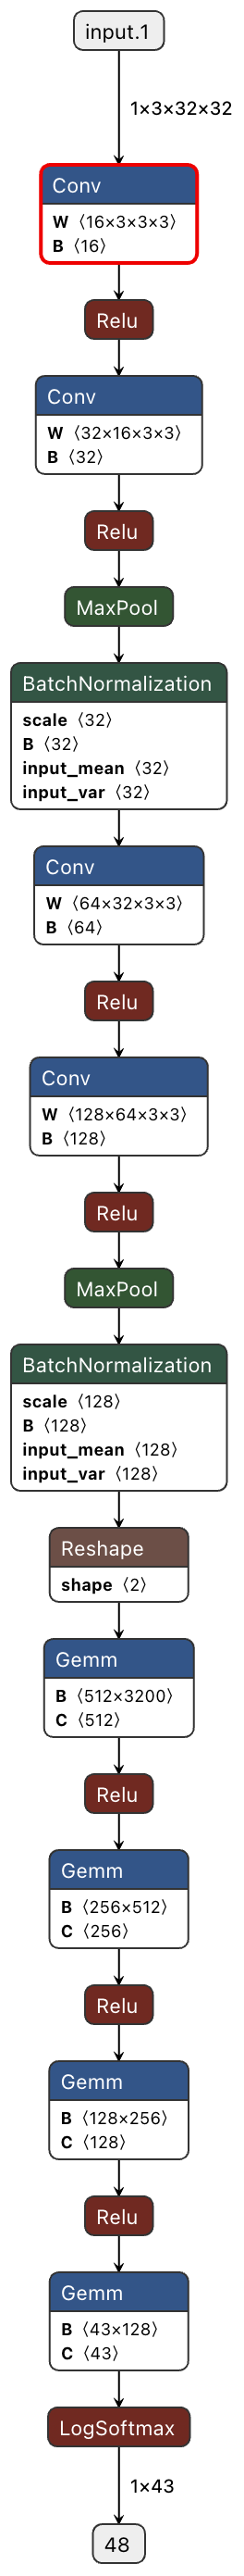

In [32]:
%pip install onnx --quiet

from IPython.display import Image

dummy_input = torch.randn(1, 3, 32, 32).to(device)
torch.onnx.export(model, dummy_input, "model.onnx", verbose=True)

print(model)
Image(filename="model.onnx.png")

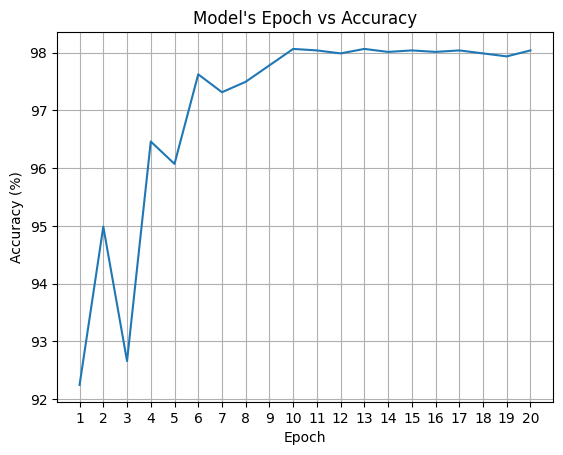

In [5]:
import matplotlib.pyplot as plt

accuracies = [x.item() * 100 for x in epoch_accuracy]

plt.plot(range(1, epochs + 1), accuracies)
plt.title('Model\'s Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.xticks(range(1, epochs + 1))
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()